## Keras MTCNN with theano as backend
#### Dependencies
1. Keras 2.0.8
2. Theano 1.0.1
3. Python2
4. OpenCV
```
sudo pip install keras
sudo pip install theano
```

In [2]:
import sys
import tools_matrix as tools
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from MTCNN import create_Kao_Onet, create_Kao_Rnet, create_Kao_Pnet

Using Theano backend.


In [3]:
Pnet = create_Kao_Pnet(r'12net.h5')
Rnet = create_Kao_Rnet(r'24net.h5')
Onet = create_Kao_Onet(r'48net.h5')  # will not work. caffe and TF incompatible

In [12]:
def detectFace(img, threshold):

    caffe_img = (img.copy() - 127.5) / 127.5
    origin_h, origin_w, ch = caffe_img.shape
    scales = tools.calculateScales(img)
    print(scales)
    out = []
    t0 = time.time()
    # del scales[:4]

    for scale in scales:
        hs = int(origin_h * scale)
        ws = int(origin_w * scale)
        scale_img = cv2.resize(caffe_img, (ws, hs))
        input = scale_img.reshape(1, *scale_img.shape)
        ouput = Pnet.predict(input)  # .transpose(0,2,1,3) should add, but seems after process is wrong then.
        out.append(ouput)
    image_num = len(scales)
    rectangles = []
    for i in range(image_num):
        cls_prob = out[i][0][0][:, :,
                   1]  # i = #scale, first 0 select cls score, second 0 = batchnum, alway=0. 1 one hot repr
        roi = out[i][1][0]
        out_h, out_w = cls_prob.shape
        out_side = max(out_h, out_w)
        # print('calculating img scale #:', i)
        cls_prob = np.swapaxes(cls_prob, 0, 1)
        roi = np.swapaxes(roi, 0, 2)
        rectangle = tools.detect_face_12net(cls_prob, roi, out_side, 1 / scales[i], origin_w, origin_h, threshold[0])
        rectangles.extend(rectangle)
    rectangles = tools.NMS(rectangles, 0.7, 'iou')

    t1 = time.time()
    print ('time for 12 net is: ', t1-t0)

    if len(rectangles) == 0:
        return rectangles

    crop_number = 0
    out = []
    predict_24_batch = []
    for rectangle in rectangles:
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (24, 24))
        predict_24_batch.append(scale_img)
        crop_number += 1

    predict_24_batch = np.array(predict_24_batch)

    out = Rnet.predict(predict_24_batch)

    cls_prob = out[0]  # first 0 is to select cls, second batch number, always =0
    cls_prob = np.array(cls_prob)  # convert to numpy
    roi_prob = out[1]  # first 0 is to select roi, second batch number, always =0
    roi_prob = np.array(roi_prob)
    rectangles = tools.filter_face_24net(cls_prob, roi_prob, rectangles, origin_w, origin_h, threshold[1])
    t2 = time.time()
    print ('time for 24 net is: ', t2-t1)


    if len(rectangles) == 0:
        return rectangles


    crop_number = 0
    predict_batch = []
    for rectangle in rectangles:
        # print('calculating net 48 crop_number:', crop_number)
        crop_img = caffe_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
        scale_img = cv2.resize(crop_img, (48, 48))
        predict_batch.append(scale_img)
        crop_number += 1

    predict_batch = np.array(predict_batch)

    output = Onet.predict(predict_batch)
    cls_prob = output[0]
    roi_prob = output[1]
    pts_prob = output[2]  # index
    # rectangles = tools.filter_face_48net_newdef(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h,
    #                                             threshold[2])
    rectangles = tools.filter_face_48net(cls_prob, roi_prob, pts_prob, rectangles, origin_w, origin_h, threshold[2])
    t3 = time.time()
    print ('time for 48 net is: ', t3-t2)

    return rectangles


[1.0, 0.709, 0.5026809999999999, 0.3564008289999999, 0.25268818776099994, 0.17915592512254896, 0.12702155091188722, 0.09005827959652803, 0.06385132023393836, 0.045270586045862295, 0.03209684550651637]
('time for 12 net is: ', 1.1301472187042236)
('time for 24 net is: ', 0.06803679466247559)
('time for 48 net is: ', 0.005410194396972656)


True

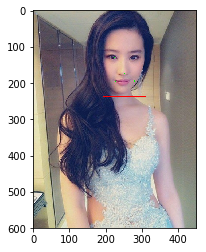

In [29]:
%matplotlib inline
threshold = [0.6,0.7,0.7]
# video_path = 'WalmartArguments_p1.mkv'
# cap = cv2.VideoCapture(video_path)
# ret, img = cap.read()
img = cv2.imread('./test/2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

rectangles = detectFace(img, threshold)
draw = img.copy()

for rectangle in rectangles:
    if rectangle is not None:
        W = -int(rectangle[0]) + int(rectangle[2])
        H = -int(rectangle[1]) + int(rectangle[3])
        paddingH = 0.01 * W
        paddingW = 0.02 * H
        
        crop_img = img[int(rectangle[1]+paddingH):int(rectangle[3]-paddingH), 
                       int(rectangle[0]-paddingW):int(rectangle[2]+paddingW)]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
        if crop_img is None:
            continue
        if crop_img.shape[0] < 0 or crop_img.shape[1] < 0: 
            continue
        cv2.rectangle(draw, (int(rectangle[0]), int(rectangle[1])), 
                      (int(rectangle[2]), int(rectangle[3])), (255, 0, 0), 1)
 
        for i in range(5, 15, 2):
            cv2.circle(draw, (int(rectangle[i + 0]), int(rectangle[i + 1])), 2, (0, 255, 0))
plt.imshow(draw)
draw = cv2.cvtColor(draw,cv2.COLOR_RGB2BGR)
cv2.imwrite("Result.jpg", draw)     